## Factors Driving Life Expectancy : Do immunization matters?

### import library 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# traitment of missing data wiht winsorize method
from scipy.stats.mstats import winsorize
# visualise missing data 
import missingno as msno
from sklearn.impute import SimpleImputer
from fancyimpute import KNN
from fancyimpute import IterativeImputer
import statsmodels.api as sm 
import pickle
import os

from library.sb_utils import save_file 

In [2]:
#kaggle datasets download -d kumarajarshi/life-expectancy-who
#import data
data = pd.read_csv('Life_Expectancy_Data.csv')

## **Data wrangling**

In [3]:
data.head(2)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0


In [4]:
data.shape

(2938, 22)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

In [6]:
# inspecting columns Name
data.columns

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')

#### 1. cleaning string - columns names

Removing space in columns name and replace '-' wiht '_'

In [7]:
initial_col=data.columns
col1=[col.strip(' ') for col in initial_col]
new_col_name1=[col.replace(' ', '_') for col in col1]
new_col_name=[col.replace('-', '_') for col in new_col_name1]
new_col_name

['Country',
 'Year',
 'Status',
 'Life_expectancy',
 'Adult_Mortality',
 'infant_deaths',
 'Alcohol',
 'percentage_expenditure',
 'Hepatitis_B',
 'Measles',
 'BMI',
 'under_five_deaths',
 'Polio',
 'Total_expenditure',
 'Diphtheria',
 'HIV/AIDS',
 'GDP',
 'Population',
 'thinness__1_19_years',
 'thinness_5_9_years',
 'Income_composition_of_resources',
 'Schooling']

In [8]:
# replace new columns name in the dataframe
data.columns=new_col_name

In [9]:
data.head(3)

,Country,Year,Status,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,Measles,...,Polio,Total_expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness__1_19_years,thinness_5_9_years,Income_composition_of_resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9


In [10]:
# expect the target Variable 
print(data[['Life_expectancy']].describe())

       Life_expectancy
count      2928.000000
mean         69.224932
std           9.523867
min          36.300000
25%          63.100000
50%          72.100000
75%          75.700000
max          89.000000


#### 2. Analyse and tread the missing values

In [11]:
#data.isna().sum() , data.isnull().sum()
MISSING= [data.isnull().sum(), 100 * data.isnull().mean()]
MISSING = pd.concat([data.isnull().sum(), 100 * data.isnull().mean()], axis=1)
MISSING.columns=['count','%'] 
MISSING.sort_values(by='%', ascending = False ) 

,count,%
Population,652,22.191967
Hepatitis_B,553,18.822328
GDP,448,15.248468
Total_expenditure,226,7.692308
Alcohol,194,6.603131
Income_composition_of_resources,167,5.684139
Schooling,163,5.547992
thinness_5_9_years,34,1.157250
thinness__1_19_years,34,1.157250
BMI,34,1.157250


Observations: according to the result above, population, Hepatitis, GDP has the highest percentage of missing value >15%

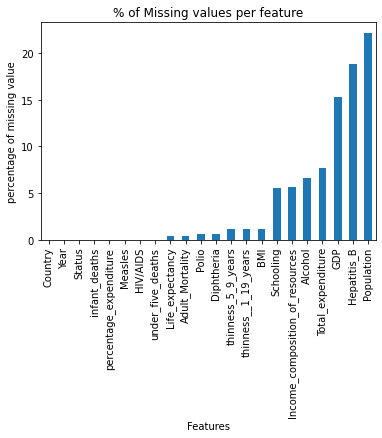

In [12]:
MISS_1=100 * data.isnull().mean().sort_values()
MISS_1.plot(kind='bar', title='% of Missing values per feature', xlabel='Features', ylabel='percentage of missing value')
plt.show()

#### 4 Detecting unsual missing values and replace wiht nan

In [13]:
# data_null = data[['Country','Status','percentage_expenditure', 'Hepatitis_B', 'GDP', 'Population']].head(5)
data[(data['Country']== 'Yemen') & (data['Population'].isnull())].head(10) 

,Country,Year,Status,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,Measles,...,Polio,Total_expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness__1_19_years,thinness_5_9_years,Income_composition_of_resources,Schooling
2890,Yemen,2015,Developing,65.7,224.0,37,NaN,0.0,69.0,468,...,63.0,NaN,69.0,0.1,NaN,NaN,13.6,13.4,0.499,9.0
2891,Yemen,2014,Developing,65.4,228.0,37,0.01,0.0,73.0,815,...,67.0,5.64,73.0,0.1,NaN,NaN,13.7,13.5,0.500,9.0
2892,Yemen,2013,Developing,65.4,226.0,36,0.04,0.0,73.0,400,...,67.0,5.78,73.0,0.1,NaN,NaN,13.7,13.5,0.498,9.0
2893,Yemen,2012,Developing,64.7,236.0,36,0.04,0.0,67.0,2177,...,68.0,5.73,67.0,0.1,NaN,NaN,13.7,13.6,0.494,9.0
2894,Yemen,2011,Developing,64.6,234.0,35,0.04,0.0,69.0,2676,...,69.0,5.40,69.0,0.1,NaN,NaN,13.7,13.6,0.493,8.6
2895,Yemen,2010,Developing,64.4,233.0,35,0.06,0.0,76.0,510,...,77.0,5.17,76.0,0.1,NaN,NaN,13.7,13.7,0.488,8.5
2896,Yemen,2009,Developing,64.1,235.0,36,0.03,0.0,76.0,130,...,76.0,5.32,76.0,0.1,NaN,NaN,13.8,13.7,0.483,8.4
2897,Yemen,2008,Developing,63.8,238.0,37,0.04,0.0,78.0,7,...,78.0,5.12,78.0,0.1,NaN,NaN,13.8,13.7,0.480,8.5
2898,Yemen,2007,Developing,63.4,24.0,38,0.05,0.0,79.0,13,...,79.0,4.92,79.0,0.1,NaN,NaN,13.8,13.8,0.477,8.6
2899,Yemen,2006,Developing,63.0,242.0,39,0.04,0.0,78.0,8079,...,78.0,4.82,78.0,0.1,NaN,NaN,13.9,13.8,0.475,8.7


Obsevration:  this result shows that percentage_expenditure has uncommun missing values which is zero

In [14]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,2938.0,2.007519e+03,4.613841e+00,2000.00000,2004.000000,2.008000e+03,2.012000e+03,2.015000e+03
Life_expectancy,2928.0,6.922493e+01,9.523867e+00,36.30000,63.100000,7.210000e+01,7.570000e+01,8.900000e+01
Adult_Mortality,2928.0,1.647964e+02,1.242921e+02,1.00000,74.000000,1.440000e+02,2.280000e+02,7.230000e+02
infant_deaths,2938.0,3.030395e+01,1.179265e+02,0.00000,0.000000,3.000000e+00,2.200000e+01,1.800000e+03
Alcohol,2744.0,4.602861e+00,4.052413e+00,0.01000,0.877500,3.755000e+00,7.702500e+00,1.787000e+01
percentage_expenditure,2938.0,7.382513e+02,1.987915e+03,0.00000,4.685343,6.491291e+01,4.415341e+02,1.947991e+04
Hepatitis_B,2385.0,8.094046e+01,2.507002e+01,1.00000,77.000000,9.200000e+01,9.700000e+01,9.900000e+01
Measles,2938.0,2.419592e+03,1.146727e+04,0.00000,0.000000,1.700000e+01,3.602500e+02,2.121830e+05
BMI,2904.0,3.832125e+01,2.004403e+01,1.00000,19.300000,4.350000e+01,5.620000e+01,8.730000e+01
under_five_deaths,2938.0,4.203574e+01,1.604455e+02,0.00000,0.000000,4.000000e+00,2.800000e+01,2.500000e+03


Observation:
#describe() help to identifty columns that may content missing value , min of these column is zero
#here, we have infant_deaths, percentage_expenditure, Measles, under_five_deaths, Income_composition_of_resources and Schooling

In [15]:
columns=data.columns
columns

Index(['Country', 'Year', 'Status', 'Life_expectancy', 'Adult_Mortality',
       'infant_deaths', 'Alcohol', 'percentage_expenditure', 'Hepatitis_B',
       'Measles', 'BMI', 'under_five_deaths', 'Polio', 'Total_expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness__1_19_years',
       'thinness_5_9_years', 'Income_composition_of_resources', 'Schooling'],
      dtype='object')

##### print the list of all columns with zero as value

In [16]:
cols_zero=[]
for col in data.columns:
    for x in data[col].unique():
        if x == 0 :
            cols_zero.append(col)
print(cols_zero) # print all the columns with zero as value

['infant_deaths', 'percentage_expenditure', 'Measles', 'under_five_deaths', 'Income_composition_of_resources', 'Schooling']


In [17]:
#ChEeck the zero is value in 'infant deaths'
data[data.infant_deaths == 0]['infant_deaths'][2::20].head(5)

18     0
129    0
165    0
185    0
221    0
Name: infant_deaths, dtype: int64

In [18]:
# count the number of zero in that columns
data[data.infant_deaths == 0]['infant_deaths'].count()

848

In [19]:
#count the number of zero in all columns

In [20]:
for col in cols_zero:
    nber_zero_col = data[data[col] == 0][col].count()
    print(col, ':', nber_zero_col)

infant_deaths : 848
percentage_expenditure : 611
Measles : 983
under_five_deaths : 785
Income_composition_of_resources : 130
Schooling : 28


In [21]:
# Make a copy of dataset before imputation
data_Zero_NAN = data.copy(deep=True)

In [22]:
#replacing uncommon missing data type with nan  
# Set the 0 values of column  to np.nan
for col in cols_zero:
    nber_zero_col = data_Zero_NAN.loc[data_Zero_NAN[col] == 0, col] = np.nan

In [23]:
# verification that the 0 value was replace with np.nan 
data_Zero_NAN[data_Zero_NAN.infant_deaths == 0]['infant_deaths'][2::20].head(5)

Series([], Name: infant_deaths, dtype: float64)

In [24]:
# verification if any columns has 0 as value
(data_Zero_NAN == 0).any()

Country                            False
Year                               False
Status                             False
Life_expectancy                    False
Adult_Mortality                    False
infant_deaths                      False
Alcohol                            False
percentage_expenditure             False
Hepatitis_B                        False
Measles                            False
BMI                                False
under_five_deaths                  False
Polio                              False
Total_expenditure                  False
Diphtheria                         False
HIV/AIDS                           False
GDP                                False
Population                         False
thinness__1_19_years               False
thinness_5_9_years                 False
Income_composition_of_resources    False
Schooling                          False
dtype: bool

#now check again the percentage of missing value in the dataFrame 

In [25]:
# percentage of missing data in each column
100 * data_Zero_NAN.isnull().mean().sort_values(ascending= False)

Measles                            33.458135
infant_deaths                      28.863172
under_five_deaths                  26.718856
Population                         22.191967
percentage_expenditure             20.796460
Hepatitis_B                        18.822328
GDP                                15.248468
Income_composition_of_resources    10.108918
Total_expenditure                   7.692308
Alcohol                             6.603131
Schooling                           6.501021
BMI                                 1.157250
thinness__1_19_years                1.157250
thinness_5_9_years                  1.157250
Polio                               0.646698
Diphtheria                          0.646698
Adult_Mortality                     0.340368
Life_expectancy                     0.340368
Year                                0.000000
HIV/AIDS                            0.000000
Status                              0.000000
Country                             0.000000
dtype: flo

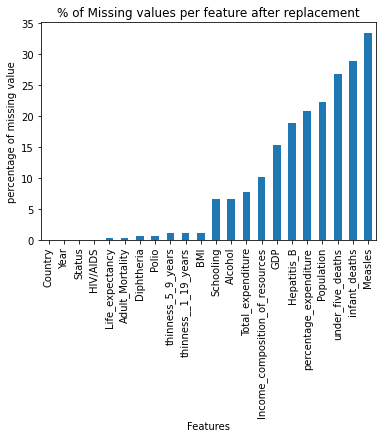

In [26]:
MISS=100 * data_Zero_NAN.isnull().mean().sort_values()
MISS.plot(kind='bar', title='% of Missing values per feature after replacement', xlabel='Features', ylabel='percentage of missing value')
plt.show()

####  5 missing data visualisation and analysis 

In [27]:
# visualise missing data 
import missingno as msno

'/usr/local/share/datasets/matrix.png'

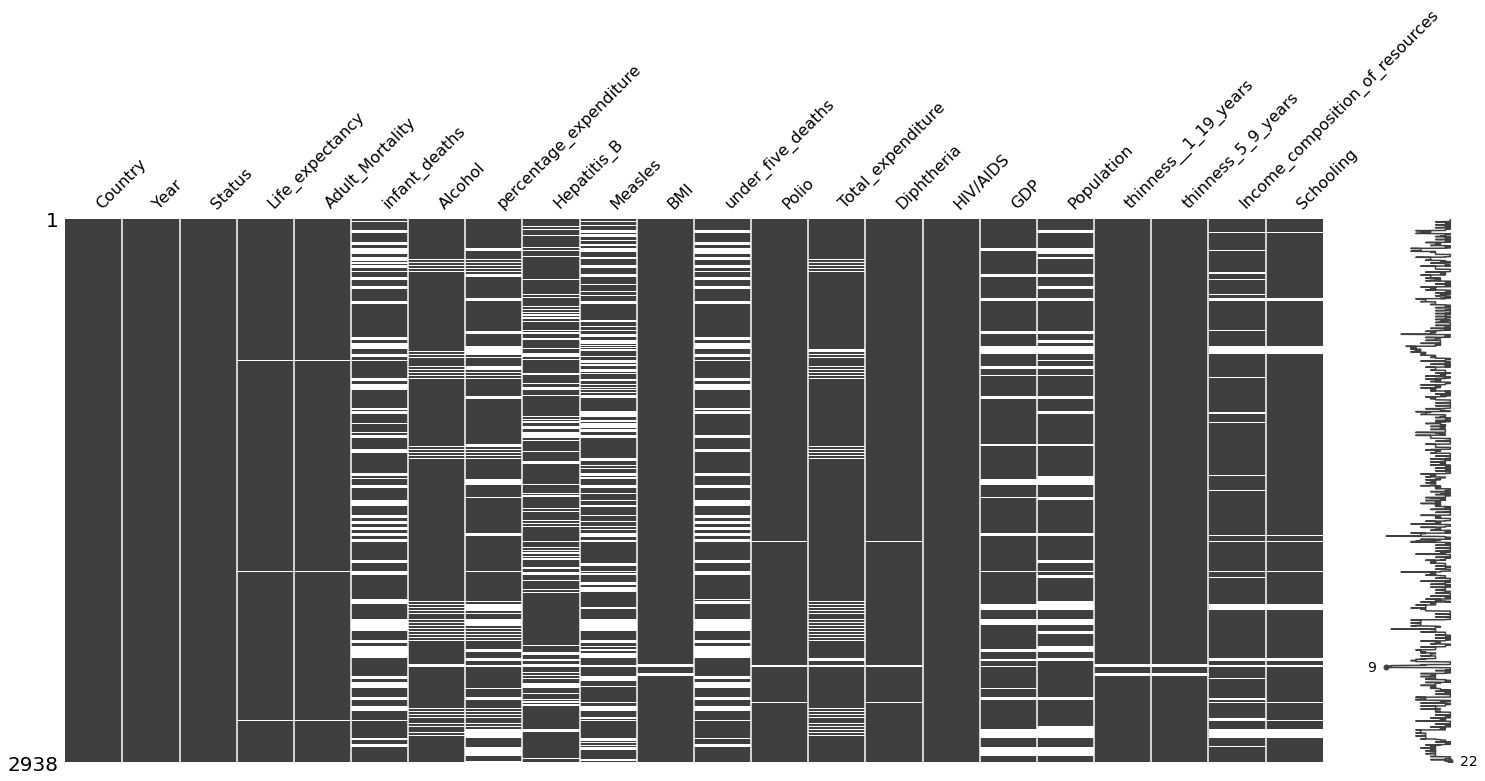

In [28]:
msno.matrix(data_Zero_NAN)
display("/usr/local/share/datasets/matrix.png")

'/usr/local/share/datasets/matrix.png'

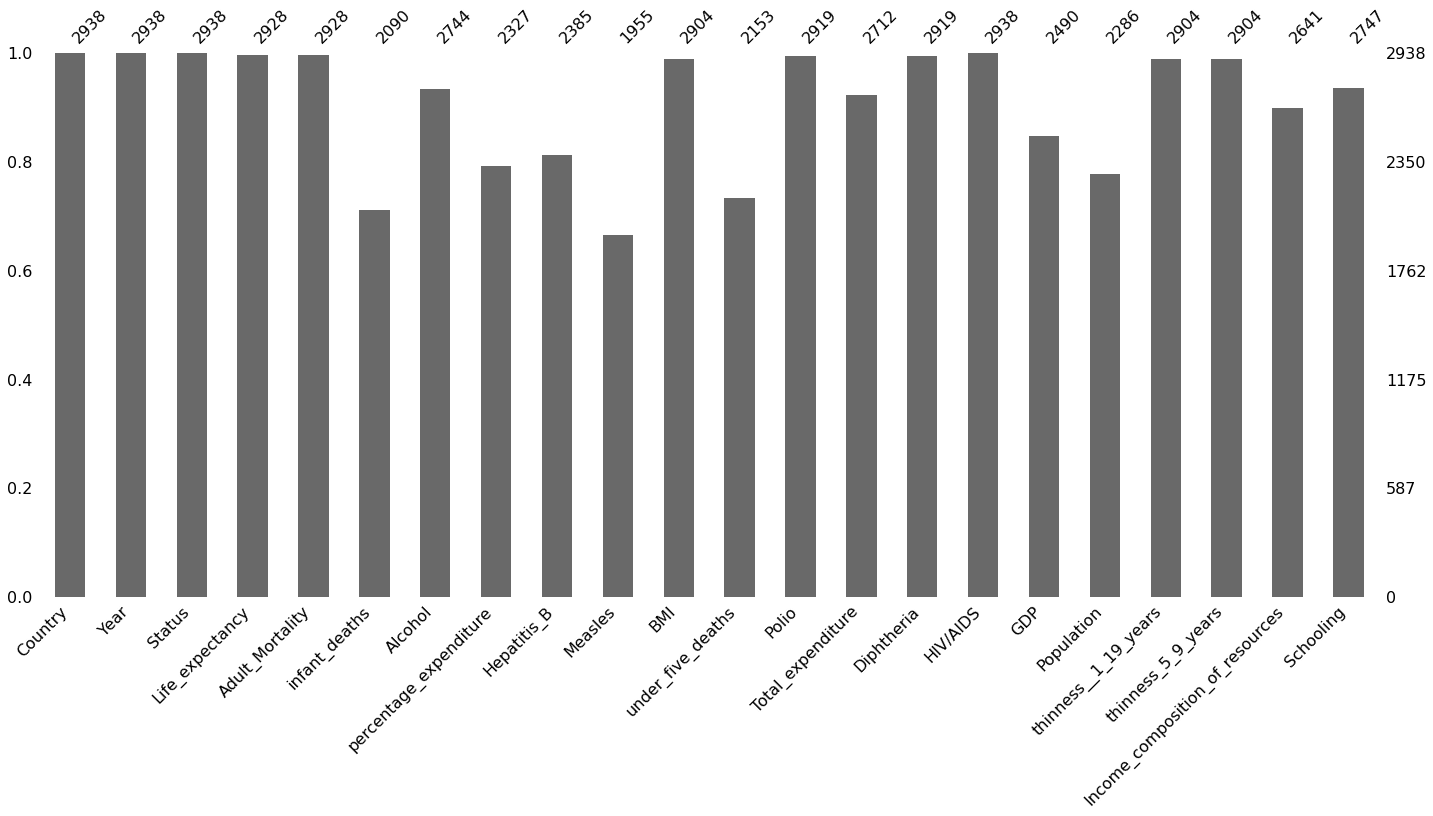

In [29]:
msno.bar(data_Zero_NAN)
display("/usr/local/share/datasets/matrix.png")

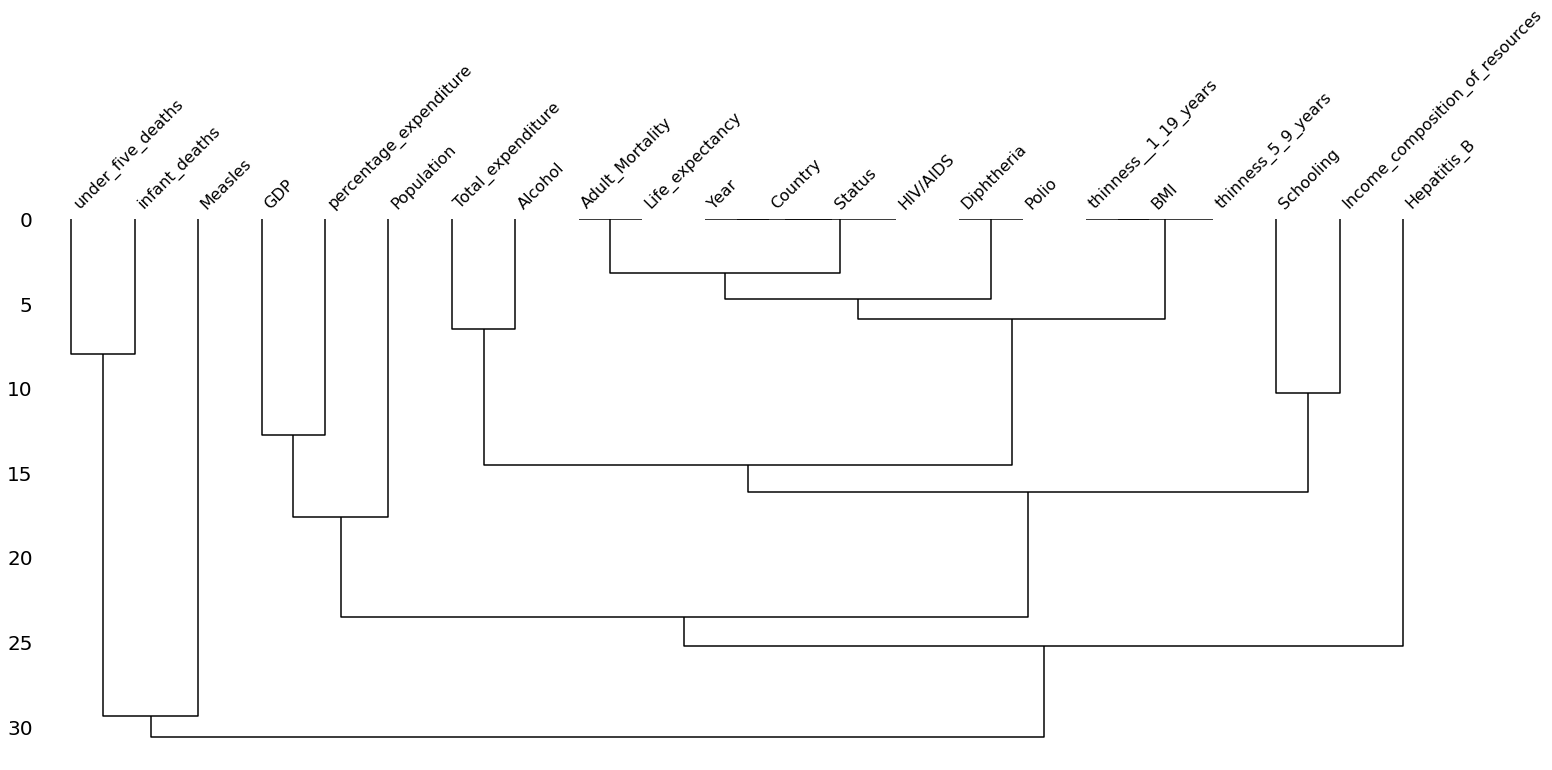

In [30]:
# Plot missingness dendrogram 
msno.dendrogram(data_Zero_NAN)
# Show plot
plt.show()

'/usr/local/share/datasets/matrix.png'

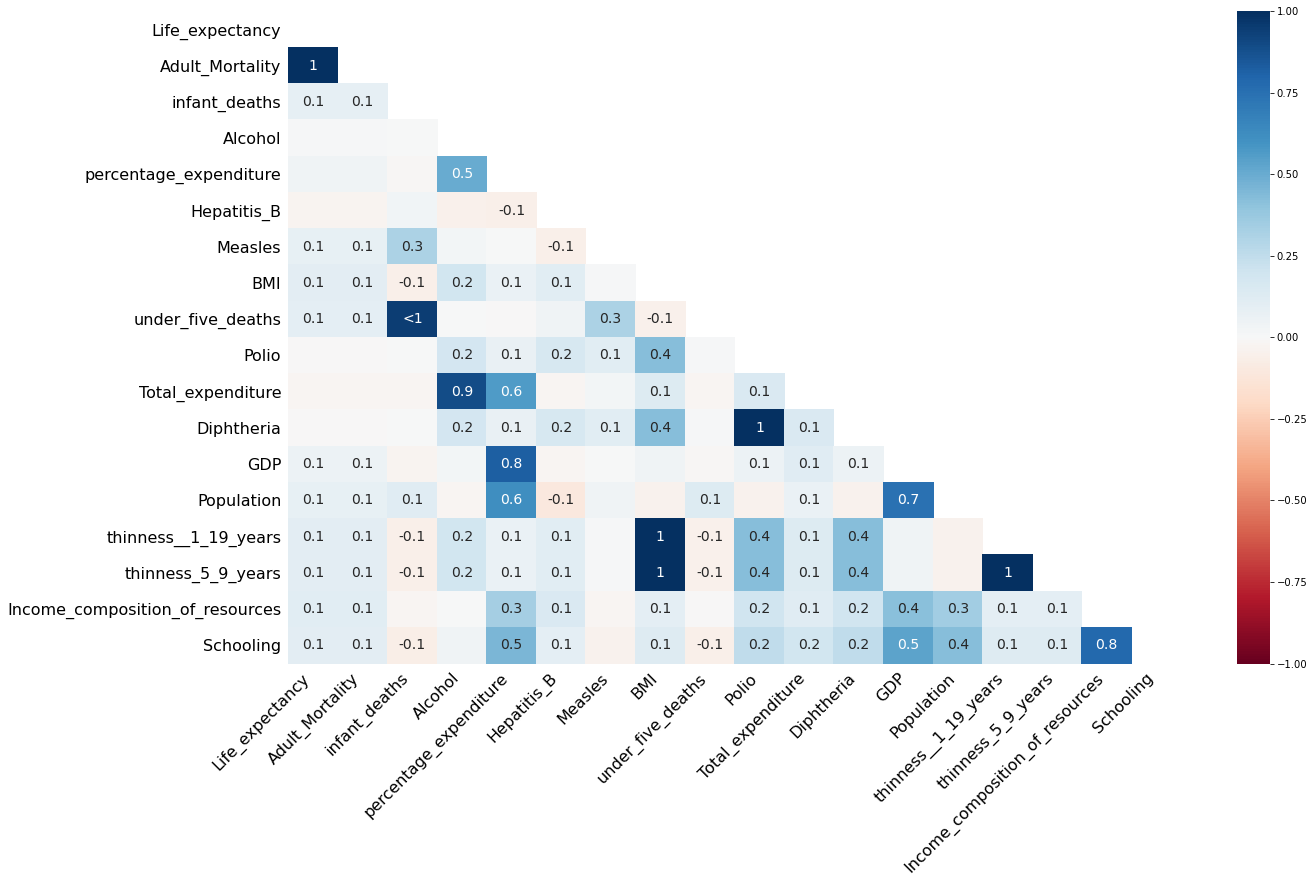

In [31]:
# Visualize the correlation of missingness between variables
msno.heatmap(data_Zero_NAN)
display("/usr/local/share/datasets/matrix.png")

#the result above show a correlation of many features 
#mortality and life_expentancy
#under_five_death and infant_deaths
#total expenditure and alcohol

#### 5.Outliers visualization and treatment

In [32]:
# https://medium.com/analytics-vidhya/outlier-treatment-9bbe87384d02
# https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-3-dcb54abaf7b0
# Applying Winzorization for Outliers
# https://www.kaggle.com/fulyakoncu/life-expectancy-who-eda-predictions
# https://www.analyticsvidhya.com/blog/2021/03/zooming-out-a-look-at-outlier-and-how-to-deal-with-them-indata-science/

#### visualization of Outliers

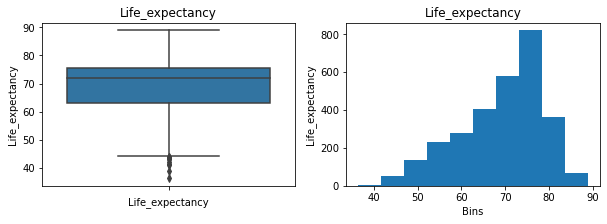

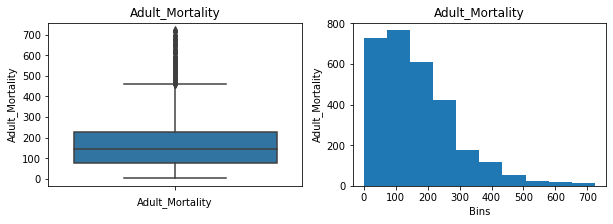

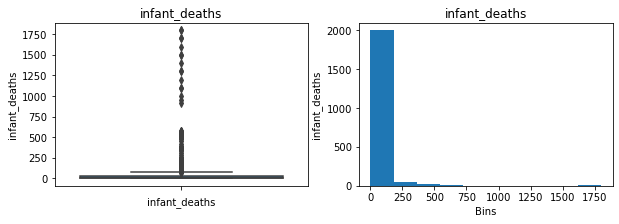

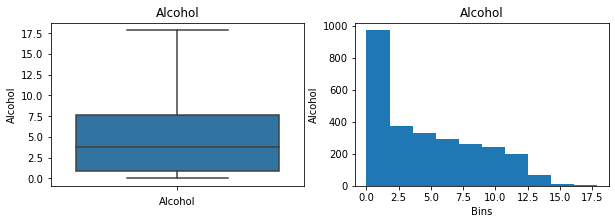

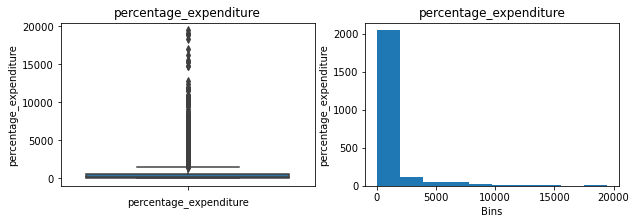

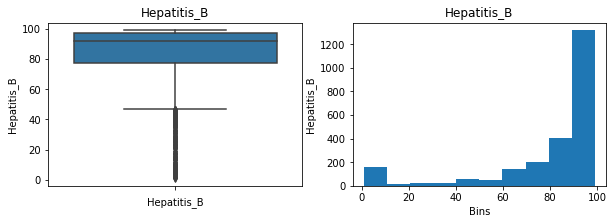

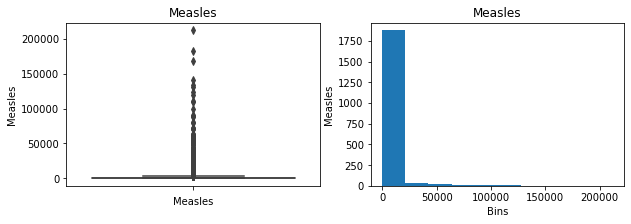

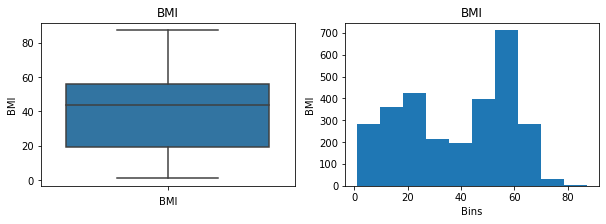

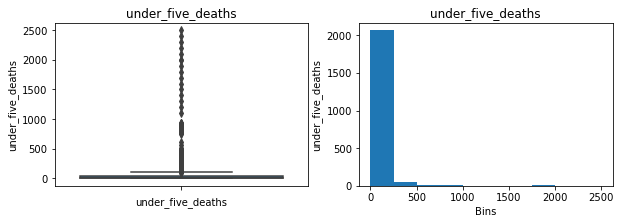

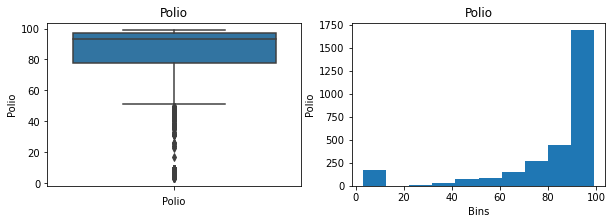

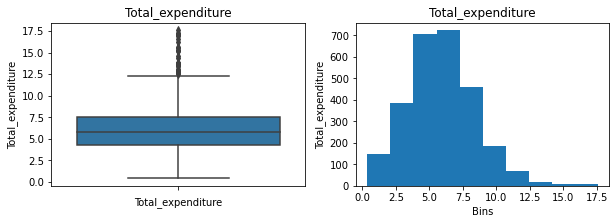

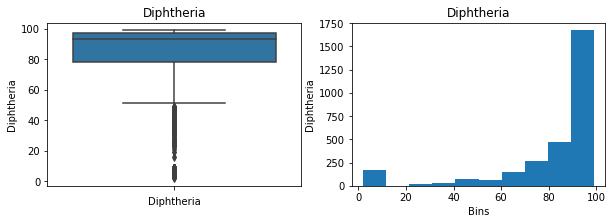

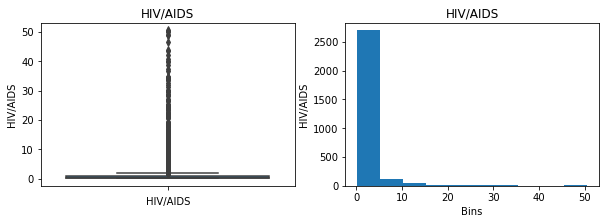

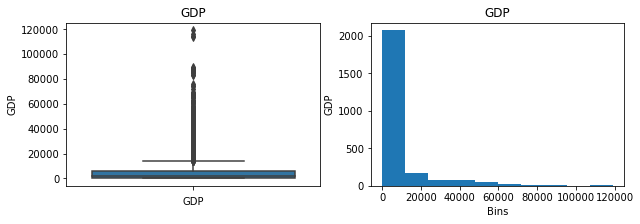

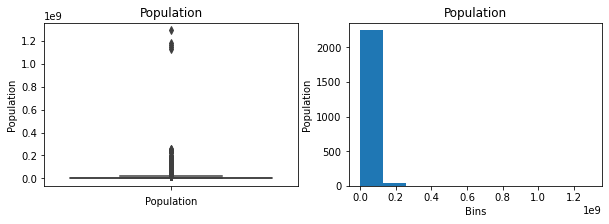

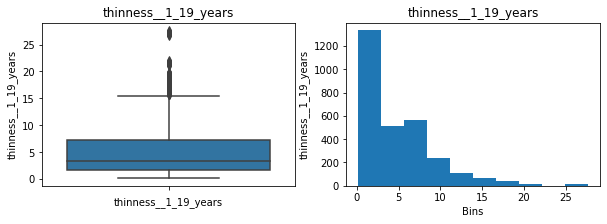

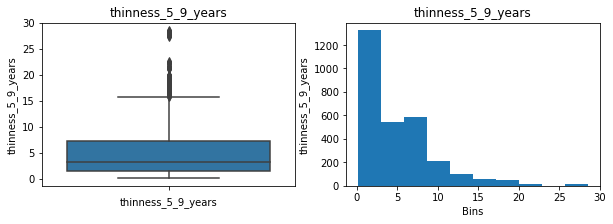

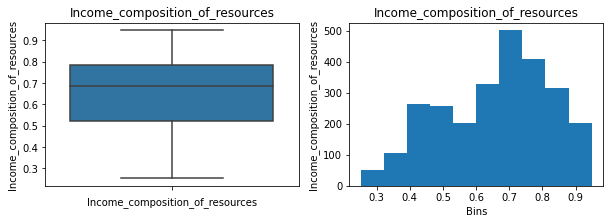

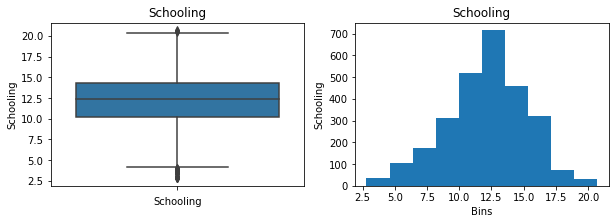

In [33]:
#colNames = df.columns.tolist()
for col in columns[3:]:
    if data_Zero_NAN[col].dtype == "object": 
        continue
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1) # one row , two columns for each columns
    #plt.boxplot(data_Zero_NAN[col]) # not working, find later why
    sns.boxplot(y=col, data=data_Zero_NAN) # refert to part one 
    plt.title(col)
    plt.ylabel(col)
    plt.xlabel(col)
    
    plt.subplot(1,2,2)
    #sns.distplot(data_Zero_NAN[col], kde=False)
    plt.hist(data_Zero_NAN[col])  # refer to par two
    plt.title(col)
    plt.ylabel(col)
    plt.xlabel('Bins')
    plt.show()

In [34]:
# number of distinct observations over requested axis. 
data_Zero_NAN.nunique(axis=0).sort_values(ascending=False)

GDP                                2490
percentage_expenditure             2327
Population                         2278
Alcohol                            1076
Measles                             957
Total_expenditure                   818
Income_composition_of_resources     624
BMI                                 608
Adult_Mortality                     425
Life_expectancy                     362
under_five_deaths                   251
infant_deaths                       208
thinness_5_9_years                  207
HIV/AIDS                            200
thinness__1_19_years                200
Country                             193
Schooling                           172
Hepatitis_B                          87
Diphtheria                           81
Polio                                73
Year                                 16
Status                                2
dtype: int64

###### TReatment of Outlier first (and next, will be the treatement of missing data 

#### Managing outlier using winsorization
In the Winsorize Method, we limit outliers with an upper and lower limit. 
We will make our upper and lower limits for data our new maximum and minimum points.

Winsorization is a symmetric process that replaces the k smallest and the k largest data values.

In [35]:
## https://hersanyagci.medium.com/detecting-and-handling-outliers-with-pandas-7adbfcd5cad8
## https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-3-dcb54abaf7b0

In [36]:
from scipy.stats.mstats import winsorize

In [37]:
# Make a copy dataset 
data_outlier_vinso = data_Zero_NAN.copy(deep=True)

In [38]:
data_outlier_vinso['Population'].quantile(0.01)

444.0

In [39]:
data_outlier_vinso['Population'].quantile(0.92)

32864644.000000007

In [40]:
Vinso_population = winsorize(data_outlier_vinso.Population, (0.01, 0.02))
Vinso_population

masked_array(data=[33736494.,   327582., 31731688., ...,   125525.,
                   12366165., 12222251.],
             mask=False,
       fill_value=1e+20)

C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


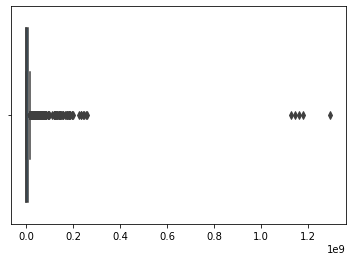

In [41]:
sns.boxplot(Vinso_population)

#### apply the Winsorize method in all features

C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


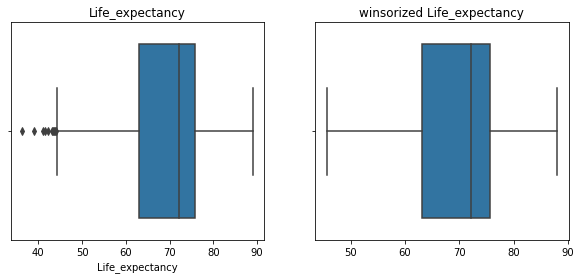

C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


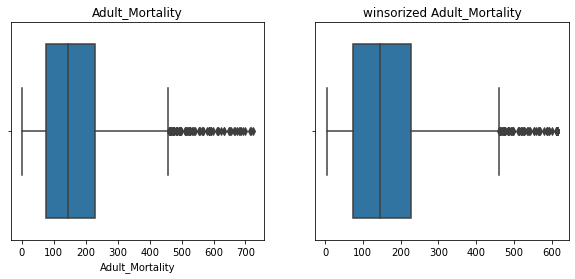

C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


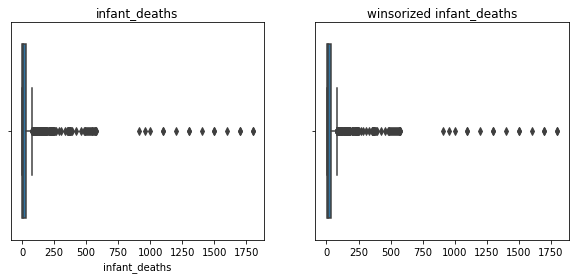

C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


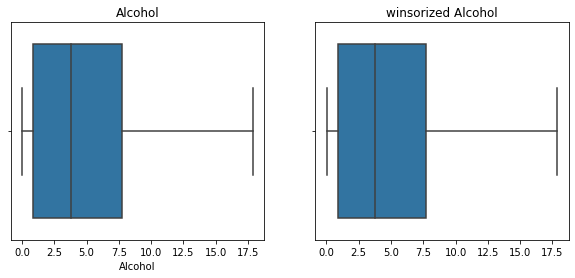

C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


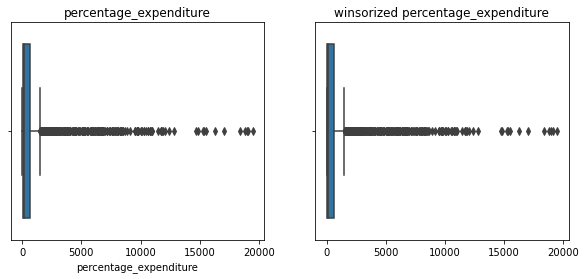

C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


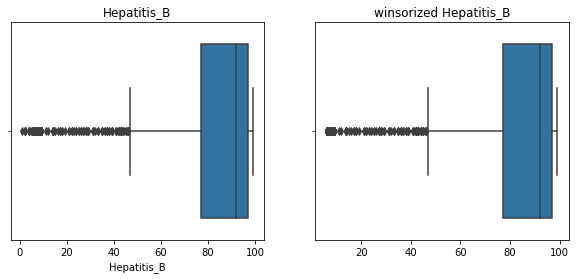

C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


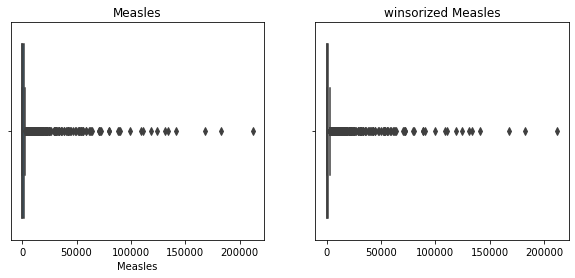

C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


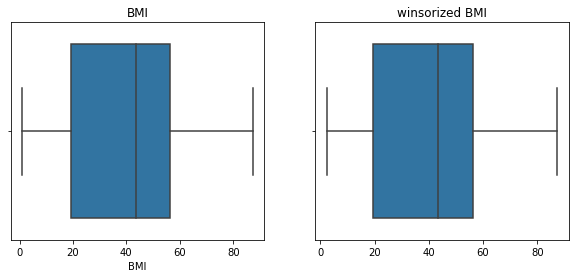

C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


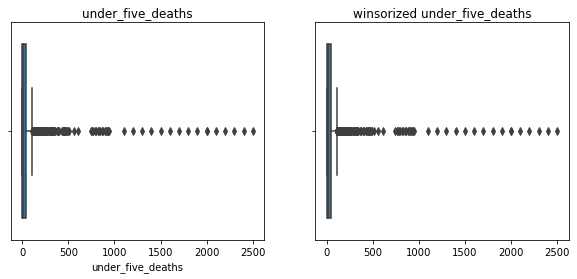

C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


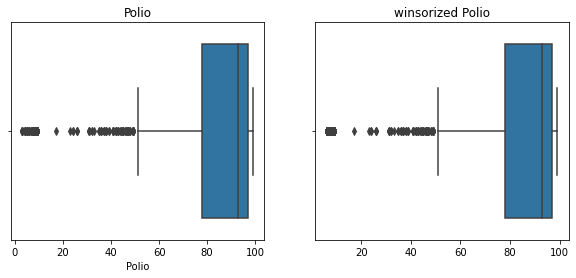

C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


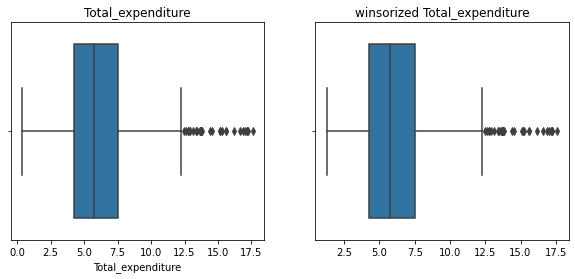

C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


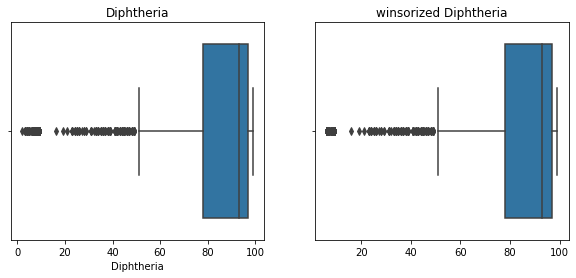

C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


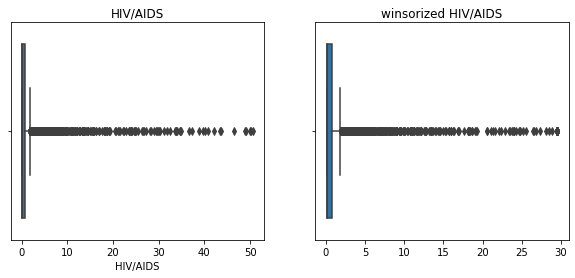

C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


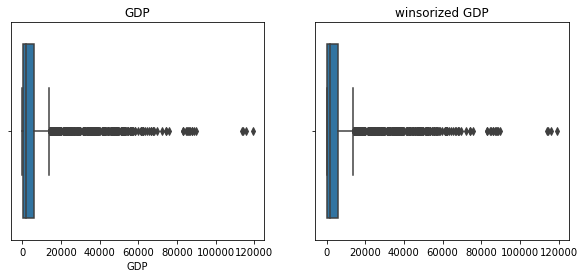

C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


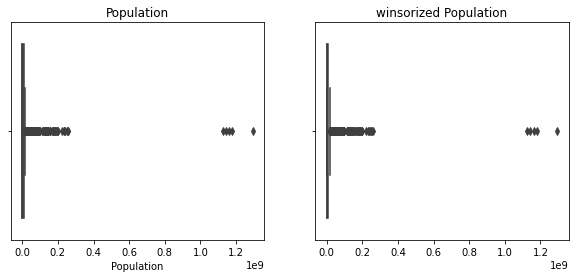

C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


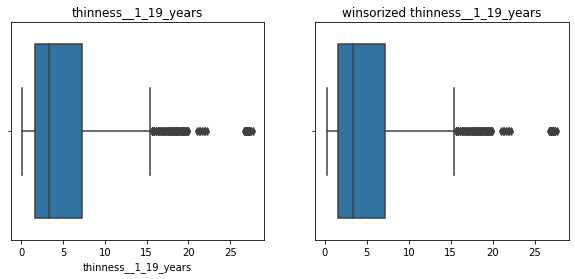

C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


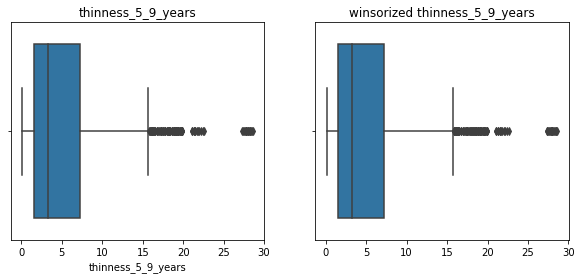

C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


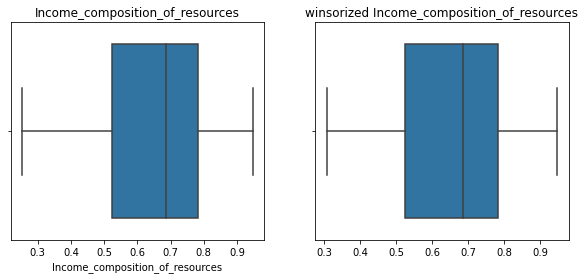

C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


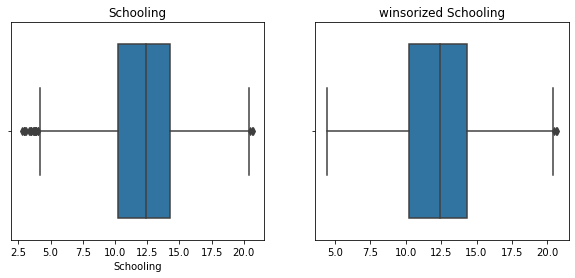

In [42]:
for col in data_outlier_vinso.columns[3:]:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    sns.boxplot(x=col,data=data_outlier_vinso)
    plt.title(col)

    plt.subplot(1,2,2)
    winsorized_data = winsorize(data_outlier_vinso[col],(0.01,0.01), inplace=True)
    sns.boxplot(winsorized_data)
    plt.title("winsorized "+col )
    plt.show()

In [43]:
# vinsorize data 
data_outlier_vinso.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,2938.0,2.007519e+03,4.613841e+00,2000.000000,2004.000000,2.008000e+03,2.012000e+03,2.015000e+03
Life_expectancy,2938.0,6.930211e+01,9.516758e+00,45.600000,63.200000,7.210000e+01,7.570000e+01,8.800000e+01
Adult_Mortality,2938.0,1.659922e+02,1.254285e+02,4.000000,74.000000,1.440000e+02,2.280000e+02,6.140000e+02
infant_deaths,2090.0,4.259952e+01,1.379414e+02,1.000000,2.000000,9.000000e+00,3.300000e+01,1.800000e+03
Alcohol,2744.0,4.602861e+00,4.052413e+00,0.010000,0.877500,3.755000e+00,7.702500e+00,1.787000e+01
percentage_expenditure,2327.0,9.320992e+02,2.192968e+03,1.142004,36.246202,1.551952e+02,6.302212e+02,1.947991e+04
Hepatitis_B,2385.0,8.095639e+01,2.502136e+01,6.000000,77.000000,9.200000e+01,9.700000e+01,9.900000e+01
Measles,1955.0,3.636195e+03,1.390055e+04,1.000000,17.000000,1.280000e+02,1.210000e+03,2.121830e+05
BMI,2904.0,3.832379e+01,2.003941e+01,2.300000,19.300000,4.350000e+01,5.620000e+01,8.730000e+01
under_five_deaths,2153.0,5.736229e+01,1.850772e+02,1.000000,3.000000,1.100000e+01,4.600000e+01,2.500000e+03


In [44]:
# non_vinzorize data  observe the difference in Min and Max columns
data_Zero_NAN.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,2938.0,2.007519e+03,4.613841e+00,2000.000000,2004.000000,2.008000e+03,2.012000e+03,2.015000e+03
Life_expectancy,2928.0,6.922493e+01,9.523867e+00,36.300000,63.100000,7.210000e+01,7.570000e+01,8.900000e+01
Adult_Mortality,2928.0,1.647964e+02,1.242921e+02,1.000000,74.000000,1.440000e+02,2.280000e+02,7.230000e+02
infant_deaths,2090.0,4.259952e+01,1.379414e+02,1.000000,2.000000,9.000000e+00,3.300000e+01,1.800000e+03
Alcohol,2744.0,4.602861e+00,4.052413e+00,0.010000,0.877500,3.755000e+00,7.702500e+00,1.787000e+01
percentage_expenditure,2327.0,9.320938e+02,2.192970e+03,0.099872,36.246202,1.551952e+02,6.302212e+02,1.947991e+04
Hepatitis_B,2385.0,8.094046e+01,2.507002e+01,1.000000,77.000000,9.200000e+01,9.700000e+01,9.900000e+01
Measles,1955.0,3.636195e+03,1.390055e+04,1.000000,17.000000,1.280000e+02,1.210000e+03,2.121830e+05
BMI,2904.0,3.832125e+01,2.004403e+01,1.000000,19.300000,4.350000e+01,5.620000e+01,8.730000e+01
under_five_deaths,2153.0,5.736229e+01,1.850772e+02,1.000000,3.000000,1.100000e+01,4.600000e+01,2.500000e+03


describe show how vinzorization act on data 
exemple: check at the minimun value of life expentancy in both table (45 over 36)

### label Encoder categerical variable 

In [45]:
data_outlier_vinso.head(3)

,Country,Year,Status,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,Measles,...,Polio,Total_expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness__1_19_years,thinness_5_9_years,Income_composition_of_resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62.0,0.01,71.279624,65.0,1154.0,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64.0,0.01,73.523582,62.0,492.0,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66.0,0.01,73.219243,64.0,430.0,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9


In [46]:
data_cat_encode = data_Zero_NAN.copy(deep=True)
data_cat_encode.head(3)

,Country,Year,Status,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,Measles,...,Polio,Total_expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness__1_19_years,thinness_5_9_years,Income_composition_of_resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62.0,0.01,71.279624,65.0,1154.0,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64.0,0.01,73.523582,62.0,492.0,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66.0,0.01,73.219243,64.0,430.0,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9


In [47]:
data_cat_encode = data_cat_encode.drop('Country', axis=1)

In [48]:
data_cat_encode = pd.get_dummies(data_cat_encode, drop_first=True)

In [49]:
data_cat_encode.insert(0,'Country', data_Zero_NAN['Country'], allow_duplicates=True)

In [50]:
data_cat_encode.sample(5)

,Country,Year,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,Measles,BMI,...,Total_expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness__1_19_years,thinness_5_9_years,Income_composition_of_resources,Schooling,Status_Developing
2030,Philippines,2008,67.5,217.0,60.0,4.21,155.476762,88.0,341.0,21.6,...,4.50,91.0,0.1,1919.466195,9751864.0,1.0,9.7,0.655,11.5,1
2460,Sudan,2012,63.2,235.0,61.0,0.01,220.522192,92.0,8523.0,NaN,...,8.20,92.0,0.3,1892.894352,3599192.0,NaN,NaN,0.468,6.8,1
2744,Ukraine,2001,67.7,253.0,6.0,4.31,8.897421,7.0,16970.0,55.1,...,5.66,99.0,0.8,78.738243,48683865.0,2.9,3.0,0.673,13.2,1
2430,Spain,2010,81.9,64.0,1.0,9.78,578.741717,97.0,302.0,63.5,...,9.56,97.0,0.1,3736.228000,46576897.0,0.6,0.5,0.860,16.4,0
2877,Viet Nam,2012,75.6,13.0,29.0,4.12,NaN,97.0,578.0,15.3,...,6.96,97.0,0.1,NaN,NaN,14.4,15.0,0.662,12.2,1


## Treatmenet of missing values 

##### 1.Mean, mode, constant & median imputation
##### 2.Imputing using fancyimpute (KNN imputation, MICE imputation)

In [51]:
 # https://medium.com/analytics-vidhya/outlier-treatment-9bbe87384d02
# https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-3-dcb54abaf7b0
# Applying Winzorization for Outliers
# https://www.kaggle.com/fulyakoncu/life-expectancy-who-eda-predictions
# https://www.analyticsvidhya.com/blog/2021/03/zooming-out-a-look-at-outlier-and-how-to-deal-with-them-indata-science

In [52]:
from sklearn.impute import SimpleImputer

###  Mean, mode, constant & median imputation

In [53]:
data_NAN_Imput = data_cat_encode.copy(deep=True)
# select only the numeric feature from the dataset
df_num = data_NAN_Imput.iloc[: , 1:]
df_num.sample(4)

,Year,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,Measles,BMI,under_five_deaths,...,Total_expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness__1_19_years,thinness_5_9_years,Income_composition_of_resources,Schooling,Status_Developing
2273,2007,73.8,132.0,1.0,9.30,772.870035,99.0,201.0,55.1,1.0,...,1.20,94.0,0.1,5458.121718,7381579.0,2.4,2.4,0.743,13.5,1
95,2000,74.1,137.0,12.0,7.68,1349.025282,NaN,6.0,54.0,14.0,...,9.21,83.0,0.1,7669.273916,3757452.0,1.2,1.1,0.764,15.0,1
374,2009,76.8,88.0,NaN,0.25,1873.686852,96.0,2.0,35.2,NaN,...,2.85,99.0,0.1,27965.475400,NaN,6.0,5.5,0.841,14.1,1
2378,2014,54.3,321.0,51.0,0.01,NaN,42.0,10229.0,23.8,80.0,...,NaN,42.0,0.8,417.891430,NaN,6.7,6.5,NaN,NaN,1


#mean imputation

In [54]:
# Make a copy of dataframe
data_NAN_mean = df_num.copy(deep=True)

# Create mean imputer object
mean_imputer = SimpleImputer(strategy='mean')

# Impute mean values in the DataFrame 
data_NAN_mean.iloc[:,:] = mean_imputer.fit_transform(data_NAN_mean)

#Median imputation

In [55]:
# Make a copy of the dataFrame
data_NAN_median = df_num.copy(deep=True)

# Create median imputer object
median_imputer = SimpleImputer(strategy='median')

# Impute median values in the DataFrame 
data_NAN_median.iloc[:, :]= median_imputer.fit_transform(data_NAN_median)

#most_frequent

In [56]:
# remove
# Make a copy of df
data_NAN_mode = df_num.copy(deep=True)

# Create mode imputer object
mode_imputer = SimpleImputer(strategy='most_frequent')

# Impute using most frequent value in the DataFrame 
data_NAN_mode.iloc[:, :]= mode_imputer.fit_transform(data_NAN_mode)

#constant 

In [57]:
# Make a copy of df
data_NAN_constant = df_num.copy(deep=True)

# Create median imputer object
constant_imputer = SimpleImputer(strategy='constant', fill_value=0)

# Impute missing values to 0 in df_constant
data_NAN_constant.iloc[:, :] = constant_imputer.fit_transform(data_NAN_constant)

####  Visualize imputations (exemple of population)

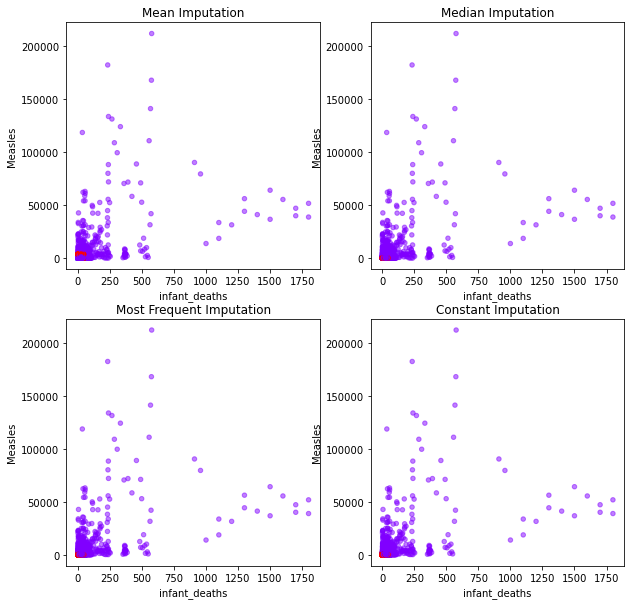

In [58]:
# Set nrows and ncols to 2
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
nullity = df_num.infant_deaths.isnull()+df_num.Measles.isnull()

# Create a dictionary of imputations
imputations = {'Mean Imputation': data_NAN_mean, 'Median Imputation': data_NAN_median, 
               'Most Frequent Imputation': data_NAN_mode, 'Constant Imputation': data_NAN_constant}

# Loop over flattened axes and imputations
for ax, df_key in zip(axes.flatten(), imputations):
    # Select and also set the title for a DataFrame
    imputations[df_key].plot(x='infant_deaths', y='Measles', kind='scatter', 
                          alpha=0.5, c=nullity, cmap='rainbow', ax=ax, 
                          colorbar=False, title=df_key)
plt.show()

### Imputing using fancyimpute

In [59]:
from fancyimpute import KNN

In [60]:
# Copy of df to df_knn_imputed
df_knn_imputed = df_num.copy(deep=True)

# Initialize KNN
knn_imputer = KNN()

# Impute using fit_tranform on diabetes_knn_imputed
df_knn_imputed.iloc[:, :] = knn_imputer.fit_transform(df_knn_imputed)

Imputing row 1/2938 with 0 missing, elapsed time: 2.144
Imputing row 101/2938 with 1 missing, elapsed time: 2.160
Imputing row 201/2938 with 0 missing, elapsed time: 2.160
Imputing row 301/2938 with 2 missing, elapsed time: 2.177
Imputing row 401/2938 with 3 missing, elapsed time: 2.177
Imputing row 501/2938 with 0 missing, elapsed time: 2.177
Imputing row 601/2938 with 1 missing, elapsed time: 2.191
Imputing row 701/2938 with 7 missing, elapsed time: 2.191
Imputing row 801/2938 with 0 missing, elapsed time: 2.207
Imputing row 901/2938 with 3 missing, elapsed time: 2.207
Imputing row 1001/2938 with 0 missing, elapsed time: 2.222
Imputing row 1101/2938 with 3 missing, elapsed time: 2.222
Imputing row 1201/2938 with 1 missing, elapsed time: 2.238
Imputing row 1301/2938 with 1 missing, elapsed time: 2.238
Imputing row 1401/2938 with 2 missing, elapsed time: 2.238
Imputing row 1501/2938 with 1 missing, elapsed time: 2.254
Imputing row 1601/2938 with 0 missing, elapsed time: 2.254
Imputing 

In [61]:
from fancyimpute import IterativeImputer

In [62]:
# Copy df_mice_imputed
df_mice_imputed = df_num.copy(deep=True)

# Initialize IterativeImputer
mice_imputer = IterativeImputer()

# Impute using fit_tranform on diabetes
df_mice_imputed.iloc[:, :] = mice_imputer.fit_transform(df_mice_imputed) # or (diabetes in fitting)

## Evaluation of different imputation techniques

In [63]:
import statsmodels.api as sm 

In [64]:
###define de baseline dataset where we drop all null value # df_base.dropna(how='any')

In [65]:
df_base = df_num.copy(deep=True)
df_base = df_base.dropna()
df_base.head(3)

,Year,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,Measles,BMI,under_five_deaths,...,Total_expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness__1_19_years,thinness_5_9_years,Income_composition_of_resources,Schooling,Status_Developing
0,2015,65.0,263.0,62.0,0.01,71.279624,65.0,1154.0,19.1,83.0,...,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,1
1,2014,59.9,271.0,64.0,0.01,73.523582,62.0,492.0,18.6,86.0,...,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,1
2,2013,59.9,268.0,66.0,0.01,73.219243,64.0,430.0,18.1,89.0,...,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,1


In [66]:
df_base.shape, df_num.shape

((911, 21), (2938, 21))

In [67]:
df_num.shape

(2938, 21)

In [68]:
print('loss of :', 100 - (911/2938)*100, '% of observation if drop all the null value of the dataset')

loss of : 68.9925119128659 % of observation if drop all the null value of the dataset


In [69]:
# higher the R_square, better the model
# Add constant to X and set X & y values to fit linear model
X = sm.add_constant(df_base.drop('Life_expectancy', axis=1))
y = df_base['Life_expectancy']
lm = sm.OLS(y, X).fit()

# Print summary of lm
print('\nSummary: ', lm.summary())

# Print R squared score of lm
print('\nAdjusted R-squared score: ', lm.rsquared_adj)

# Print the params of lm
print('\nCoefficcients:\n', lm.params)


Summary:                              OLS Regression Results                            
Dep. Variable:        Life_expectancy   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     407.4
Date:                Wed, 26 Jan 2022   Prob (F-statistic):               0.00
Time:                        15:27:14   Log-Likelihood:                -2284.4
No. Observations:                 911   AIC:                             4611.
Df Residuals:                     890   BIC:                             4712.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [70]:
# perform regression -on Mean Imputation data 
X = sm.add_constant(data_NAN_mean.drop('Life_expectancy', axis=1))
y = data_NAN_mean['Life_expectancy']
lm_mean = sm.OLS(y, X).fit()

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [71]:
#KNN imputation (missing value)
X = sm.add_constant(df_knn_imputed.drop('Life_expectancy', axis=1))
y = df_knn_imputed['Life_expectancy']
lm_KNN = sm.OLS(y, X).fit()

In [72]:
#MIce imputation 
X = sm.add_constant(df_mice_imputed.drop('Life_expectancy', axis=1))
y = df_mice_imputed['Life_expectancy']
lm_MICE = sm.OLS(y, X).fit()

In [73]:
#constant imputation
X = sm.add_constant(data_NAN_constant.drop('Life_expectancy', axis=1))
y = data_NAN_constant['Life_expectancy']
lm_constant = sm.OLS(y, X).fit()

In [74]:
#mode imputation 
X = sm.add_constant(data_NAN_mode.drop('Life_expectancy', axis=1))
y = data_NAN_mode['Life_expectancy']
lm_mode = sm.OLS(y, X).fit()

In [75]:
# Store the Adj. R-squared scores of the linear models
r_squared = pd.DataFrame({'Complete Case': lm.rsquared_adj, 
                          'Mean Imputation': lm_mean.rsquared_adj, 
                          'KNN Imputation': lm_KNN.rsquared_adj, 
                          'MICE Imputation': lm_MICE.rsquared_adj,
                         'Constant Imputation': lm_constant.rsquared_adj,
                          'Mode Imputation': lm_mode.rsquared_adj}, 
                         index=['Adj. R-squared'])

print(r_squared)

                Complete Case  Mean Imputation  KNN Imputation  \
Adj. R-squared       0.899322         0.837261        0.857469   

                MICE Imputation  Constant Imputation  Mode Imputation  
Adj. R-squared         0.900985             0.665765         0.835953  


In [76]:
# Store the coefficients of the linear models
coeff = pd.DataFrame({'Complete Case': lm.params, 
                          'Mean Imputation': lm_mean.params, 
                          'KNN Imputation': lm_KNN.params, 
                          'MICE Imputation': lm_MICE.params,
                     'Constant Imputation': lm_constant.params,
                     'Mode Imputation': lm_mode.params})

print(coeff)

                                 Complete Case  Mean Imputation  \
const                             1.241645e+02    -4.436321e+01   
Year                             -3.879148e-02     4.697046e-02   
Adult_Mortality                  -1.185839e-02    -1.807375e-02   
infant_deaths                     4.602511e-02     6.425967e-02   
Alcohol                          -2.343951e-01    -2.166859e-02   
percentage_expenditure            6.813511e-04     1.949084e-04   
Hepatitis_B                      -5.690675e-03    -1.829682e-02   
Measles                           7.188949e-06    -2.759216e-05   
BMI                               5.642678e-03     2.465383e-02   
under_five_deaths                -3.519076e-02    -4.822437e-02   
Polio                             1.319779e-03     2.152312e-02   
Total_expenditure                 1.394432e-01     1.443986e-01   
Diphtheria                        1.624337e-02     3.863165e-02   
HIV/AIDS                         -3.354830e-01    -3.967129e-0

## Select the best imputation based on the R-squared score.

In [77]:
r_squares = {'Mean Imputation': lm_mean.rsquared_adj, 
             'KNN Imputation': lm_KNN.rsquared_adj, 
             'MICE Imputation': lm_MICE.rsquared_adj,
            'Constant Imputation': lm_constant.rsquared_adj,
            'Mode Imputation': lm_mode.rsquared_adj}

# Select best R-squared / use max(), the higher R-square, better the model
best_imputation = max(r_squares, key=r_squares.get)

print("The best imputation technique is: ", best_imputation)

The best imputation technique is:  MICE Imputation


#### Visualize the implication if imputation on Population-  density plot

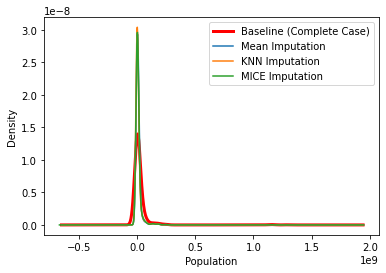

In [78]:
# Plot graphs of imputed DataFrames and the complete case
df_base['Population'].plot(kind='kde', c='red', linewidth=3)
data_NAN_mean['Population'].plot(kind='kde') # diabetes_mean / diabetes_mean_imputed
df_knn_imputed['Population'].plot(kind='kde')
df_mice_imputed['Population'].plot(kind='kde')

# Create labels for the four DataFrames
labels = ['Baseline (Complete Case)', 'Mean Imputation', 'KNN Imputation', 'MICE Imputation']
plt.legend(labels)

# Set the x-label as Skin Fold
plt.xlabel('Population')

plt.show()

#### Save dataset 

In [79]:
#import os
#import pickle
#from library.sb_utils import save_file

1.data_Zero_NAN # Raw data -- replace 0 with NaN 

2.data_outlier_vinso # Raw data -- replace 0 with NaN --, outlier treated with winzorisation

3.data_cat_encode.- Raw data -- replace 0 with NaN --winsorize and- label encoder of cat var (Status_Developing) (1 - develp , 0- )

In [80]:
# Raw data -- replace 0 with NaN --- label encoder of cat var (Status_Developing) (1 - develp , 0- )
data_cat_encode.head(3)

,Country,Year,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,Measles,BMI,...,Total_expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness__1_19_years,thinness_5_9_years,Income_composition_of_resources,Schooling,Status_Developing
0,Afghanistan,2015,65.0,263.0,62.0,0.01,71.279624,65.0,1154.0,19.1,...,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,1
1,Afghanistan,2014,59.9,271.0,64.0,0.01,73.523582,62.0,492.0,18.6,...,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,1
2,Afghanistan,2013,59.9,268.0,66.0,0.01,73.219243,64.0,430.0,18.1,...,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,1


In [81]:
# the best imputation with mice------- mice - dataset 
#( replace 0 with NaN --- label encoder of cat var (Status_Developing) (1 - develp , 0- ) , mice imputation)
df_mice_imputed.head(3)

,Year,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,Measles,BMI,under_five_deaths,...,Total_expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness__1_19_years,thinness_5_9_years,Income_composition_of_resources,Schooling,Status_Developing
0,2015.0,65.0,263.0,62.0,0.01,71.279624,65.0,1154.0,19.1,83.0,...,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,1.0
1,2014.0,59.9,271.0,64.0,0.01,73.523582,62.0,492.0,18.6,86.0,...,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,1.0
2,2013.0,59.9,268.0,66.0,0.01,73.219243,64.0,430.0,18.1,89.0,...,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,1.0


In [82]:
# the best imputation is mean - dataset 
data_NAN_mean.head(2)

,Year,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,Measles,BMI,under_five_deaths,...,Total_expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness__1_19_years,thinness_5_9_years,Income_composition_of_resources,Schooling,Status_Developing
0,2015.0,65.0,263.0,62.0,0.01,71.279624,65.0,1154.0,19.1,83.0,...,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,1.0
1,2014.0,59.9,271.0,64.0,0.01,73.523582,62.0,492.0,18.6,86.0,...,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,1.0


'/usr/local/share/datasets/matrix.png'

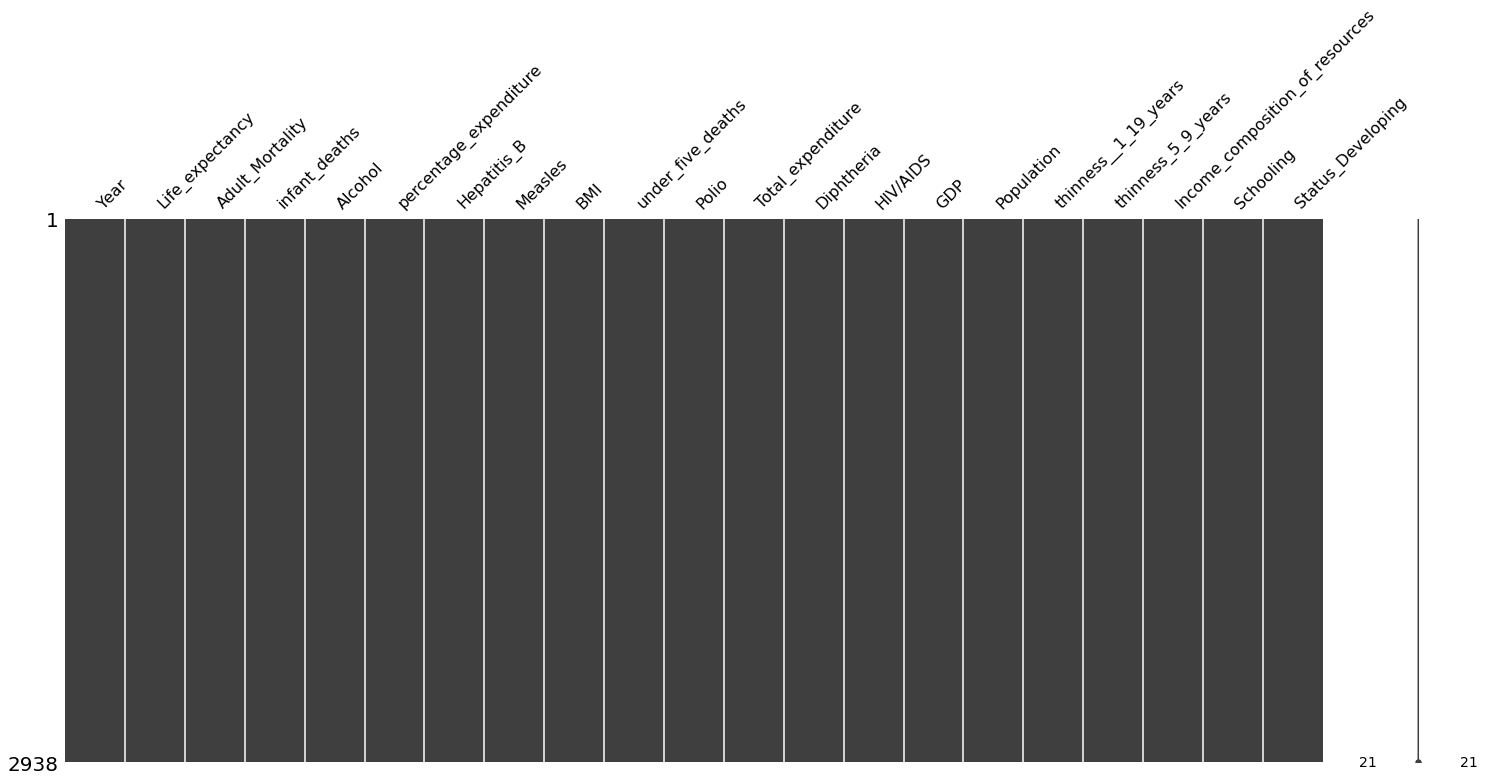

In [83]:
msno.matrix(df_mice_imputed)
display("/usr/local/share/datasets/matrix.png")

In [84]:
# add the first column to mice dataset 
df_mice_imputed.insert(0,'Country', data_cat_encode['Country'], allow_duplicates=True)

In [85]:
df_mice_imputed.head(3)

,Country,Year,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,Measles,BMI,...,Total_expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness__1_19_years,thinness_5_9_years,Income_composition_of_resources,Schooling,Status_Developing
0,Afghanistan,2015.0,65.0,263.0,62.0,0.01,71.279624,65.0,1154.0,19.1,...,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,1.0
1,Afghanistan,2014.0,59.9,271.0,64.0,0.01,73.523582,62.0,492.0,18.6,...,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,1.0
2,Afghanistan,2013.0,59.9,268.0,66.0,0.01,73.219243,64.0,430.0,18.1,...,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,1.0


In [86]:
# add the first column to mice dataset 
data_NAN_mean.insert(0,'Country', data_cat_encode['Country'], allow_duplicates=True)
data_NAN_mean.head(3)

,Country,Year,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,Measles,BMI,...,Total_expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness__1_19_years,thinness_5_9_years,Income_composition_of_resources,Schooling,Status_Developing
0,Afghanistan,2015.0,65.0,263.0,62.0,0.01,71.279624,65.0,1154.0,19.1,...,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,1.0
1,Afghanistan,2014.0,59.9,271.0,64.0,0.01,73.523582,62.0,492.0,18.6,...,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,1.0
2,Afghanistan,2013.0,59.9,268.0,66.0,0.01,73.219243,64.0,430.0,18.1,...,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,1.0


In [87]:
# Save the data 
datapath = '../data'
save_file(df_mice_imputed, 'life_exp_imput_mice.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)n

Please re-run this cell with a new filename.


In [88]:
#data_Zero_NAN # Raw data -- replace 0 with NaN 
save_file(data_NAN_mean, 'life_exp_imput_mean.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)y
Writing file.  "../data\life_exp_imput_mean.csv"


In [89]:
#data_Zero_NAN # Raw data -- replace 0 with NaN 
save_file(data_Zero_NAN, 'life_exp_Zero_Nan.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)y
Writing file.  "../data\life_exp_Zero_Nan.csv"
